<a href="https://colab.research.google.com/github/ImolaFodor/probabilistic-ML/blob/main/HW06_PML_IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 6, Probabilistic ML @ units

by Imola Fodor

All HW-s in .html can be found at: https://github.com/ImolaFodor/probabilistic-ML/

The UCI ML hand-written digits datasets contains 8x8 images of digits belonging to 10 different classes:

In [1]:
import sklearn
from sklearn.datasets import load_digits
import numpy as np

dataset = load_digits()
x, y = dataset.data, dataset.target
print("predictors shape =", x.shape)
print("labels shape =", y.shape)
print("n. unique labels =", len(np.unique(y)))


predictors shape = (1797, 64)
labels shape = (1797,)
n. unique labels = 10


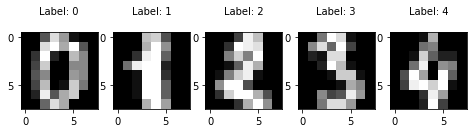

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
for index, (image, label) in enumerate(zip(x[0:5], y[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
 plt.title('Label: %i\n' % label, fontsize = 10)

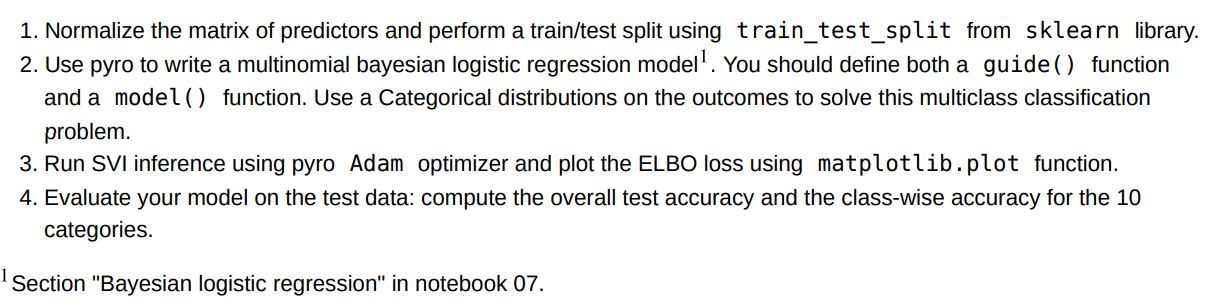

In [3]:
def one_hot_encode(vector):
    n_classes = len(vector.unique())  # 1
    one_hot = torch.zeros((vector.shape[0], n_classes))\
        .type(torch.LongTensor)  # 2
    return one_hot\
        .scatter(1, vector.type(torch.LongTensor).unsqueeze(1), 1)  # 3

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch

scaler = preprocessing.StandardScaler().fit(x)
x_scaled = scaler.transform(x)


x_train, x_test, y_train, y_test = train_test_split(x_scaled, 
                                                    y, 
                                                    test_size=0.1, 
                                                    random_state=1)

x_train = torch.from_numpy(x_train)

y_train = torch.from_numpy(y_train)
y_train = one_hot_encode(y_train)

x_test = torch.from_numpy(x_test)

y_test = torch.from_numpy(y_test)
y_test = one_hot_encode(y_test)

In [5]:
!pip3 install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 8.6 MB/s 


For the prediction of a bivariate output, in logistic regression, we use the combination of multiple linear regression with a normalization through the sigmoid function to get a valid probability value. 

For the multinomial logistic classifier we’ll need separate weight vectors $w_k$ and bias $b_k$ for each of the K
classes. We have multiple features describing the images, hence the need to have separate weight vectors and biases for each of the K classes, in our case 10.
As the non-linear function this classifier can use a generalization of the sigmoid, called the softmax function.

For a vector z of dimensionality K, the softmax is defined as:

> $softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{K}{exp(z_j)}}$ where 1 ≤ i ≤ K

Finally, combining the above statements, we have that a class $y_k$ (of K possible ones), gets to be predicted through the formula:

> $p(\boldsymbol{y_k} = 1|\boldsymbol{x}) = \frac{exp(\boldsymbol{w_k}\boldsymbol{x}+b_k)}{\sum_{j=1}^{K}{exp(\boldsymbol{w_j}\boldsymbol{x}+b_j)}}$

We sample classification labels from a Categorical distribution.

> $y \sim Categorical(p_K) $




\* in bold the vectors

In [6]:
y_train.shape[1]

10

In [17]:
import pyro
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch.nn as nn

# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

def model(x, y):

  n_observations, n_predictors = x.shape
  n_classes = y.shape[1]
  W = torch.DoubleTensor(n_predictors, n_classes)
  W = W.zero_()

  b = torch.DoubleTensor(n_classes)
  b = b.zero_()
  
  for i in pyro.plate("latent", n_classes):
    w = pyro.sample("w_{}".format(i), dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_k = pyro.sample("b_{}".format(i), dist.Normal(0.,1.))
    W[:, i] = w
    b[i] = b_k
  
  # non-linearity
  m = nn.Softmax(dim=1)
  yhat = m(torch.mm(x,W) + b)
  #print(torch.sum(yhat[1, :])) # sums to one

  with pyro.plate("data", n_observations):
   y = pyro.sample("y", dist.Categorical(probs=yhat), obs=y)



In [13]:
def guide(x, y=None):

 n_observations, n_predictors = x.shape
 n_classes = 10
 W = torch.DoubleTensor(n_predictors, n_classes)
 W = W.zero_()

 b = torch.DoubleTensor(n_classes)
 b = b.zero_()

 w_loc = pyro.param("w_loc", torch.rand(n_predictors))
 w_scale = pyro.param("w_scale", torch.rand(n_predictors),
 constraint=constraints.positive)

 b_loc = pyro.param("b_loc", torch.rand(1))
 b_scale = pyro.param("b_scale", torch.rand(1),
 constraint=constraints.positive)
 
 for i in pyro.plate("latent", n_classes):
  w = pyro.sample("w_{}".format(i), dist.Normal(w_loc, w_scale))
  b_k = pyro.sample("b_{}".format(i), dist.Normal(b_loc,b_scale))

In [18]:
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

m_log_reg_svi = SVI(model=model, guide=guide,
 optim=optim.Adam({'lr' : 0.0002}),
 loss=Trace_ELBO())
losses = []

for step in range(10000):
 loss = m_log_reg_svi.step(x_train,y_train.float())/len(x_train)
 losses.append(loss)
 if step % 1000 == 0:
  print(f"Step {step} : loss = {loss}")

fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

ValueError: ignored

In [ ]:
def predict_class(x):
 w_loc = pyro.get_param_store()["w_loc"]
 b_loc = pyro.get_param_store()["b_loc"]
 w_scale = pyro.get_param_store()["w_scale"]
 b_scale = pyro.get_param_store()["b_scale"]

 W = torch.DoubleTensor(64, 10)
 W = W.zero_()

 b = torch.DoubleTensor(10)
 b = b.zero_()

 for i in pyro.plate("logits", 10):
  w = pyro.sample("w_{}".format(i), dist.Normal(w_loc, w_scale))
  b_k = pyro.sample("b_{}".format(i), dist.Normal(b_loc,b_scale))
  W[:, i] = w
  b[i] = b_k

 m = nn.Softmax(dim=1)
 out = m(torch.mm(x,W) + b_k)
 return (out>0.4)


In [ ]:
print(torch.sum(predict_class(x_test)))
print(torch.sum(predict_class(x_test)[1, :]))

correct_predictions = (predict_class(x_test) == y_test).all(dim=1).float().mean()
print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")